In [85]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray
import pandas as pd
import seaborn as sns

In [84]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 10
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[2:4],
            1: devices[6:8],
            2: devices[-2:],
            # 3: devices[:bound]
            3: [0]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def false_free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.s_capacity
            # if load[i] <= self.min_free_space:
            #     self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def compute_normalized_latency_dict(self):    # CHANGEEEEEEEEEEEEEE
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # def rl_update(self, new_allocation):
    #     self.data_allocation = new_allocation
    #     self.construct_dictionaries()
    #     return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0] # CHANGEEEEEEEEEEEEEEE
            # device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]  # CHANGEEEEEEEEEEEEEEEEEEEEE
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:      # CHANGEEEEEEEEEEEEEEEEEEEEE
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0          # CHANGEEEEEEEEEEEEEEEEEEEEE
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(122 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(122 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

In [5]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture()
print(architecture.clusters)

for i in range(3):
    for j in executions:
        architecture.heart_beat()
        for h in j:
            architecture.generate(h)
print(architecture.data_allocation)
print(len(architecture.data_allocation))
# print(architecture.data)
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.round_robin()
# print(architecture.compute_normalized_latency_dict())
# architecture.greedy_server()
# print(architecture.compute_normalized_latency_dict())

{0: [2, 3], 1: [6, 7], 2: [10, 11], 3: [0]}
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
80


In [6]:
# 6: [2,4,4,3]
# 10: [3,6,6,5]
# 16: [4.5,9,9,8]
class AcesStepArchitectureEnv(Env):
    def __init__(self, num_stations):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.num_stations = num_stations
        self.multipliers = {
            6: [2,4,4,3],
            10: [3,6,6,5],
            16: [4.5,9,9,8]
        }

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity]

        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)
            self.max_free_space.append(self.architecture.s_capacity)

        self.last_call = [-1]
        self.weight = 0
        self.type = 0
        self.flag = False

        self.observation_space = Dict({
            "weight": Box(low=0, high=5, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-10, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=self.num_devices-1, shape=(2,), dtype=np.int32)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(2,), dtype=np.int32)

        self.reward = 0

    def get_obs(self, type):
        self.weight = self.architecture.weights[type] * self.multipliers[self.num_stations][type]
        self.flag = True if self.flag == False else False
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]
        return {
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        latency = 0
        alert = False
        computed_latencies = 0
        for location in action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight
        for i in range(len(self.free_space)):
            if self.free_space[i] <= self.max_free_space[i]*0.2:
                alert = True

        reward = -1 if alert else 1 - (latency / (computed_latencies * 22+1))

        done = False
        info = {'type': self.type}

        if self.type == 3 and self.flag == False:
            done = True
        if self.type !=3:
            if self.flag == False:
                self.type += 1

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)

        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        self.iter = 0
        self.flag=False
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

In [7]:
ar = AcesStepArchitectureEnv(10)

In [17]:
ar.reset()

{'weight': array([0.0375]),
 'free_space': array([50, 50,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]),
 'last_calls': array([ 3, -1])}

In [25]:
ar.step(ar.action_space.sample())

({'weight': array([2.5]),
  'free_space': array([50.    , 49.88  ,  1.8425,  2.    ,  1.8425, -0.512 ,  2.    ,
          1.9565,  1.9625,  1.994 , -0.62  , -3.    ]),
  'last_calls': array([-1, -1])},
 -1,
 True,
 {'type': 3})

In [83]:
ar.step(ar.action_space.sample())
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(10)
check_env(EnvCompatibility(simulated_aces))

In [27]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(10)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

config["model"]["fcnet_hiddens"] =[64,64]


algorithm_unified_10 = config.build()

result_unified_10 =[]

for j in tqdm(range(50)):
    result_train = algorithm_unified_10.train()["episode_reward_mean"]
    result_unified_10.append(result_train)
    # if (j%100 == 0):
    print(result_train)
print(result_unified_10)

2023-06-22 23:19:20,045	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-22 23:19:32,997	INFO trainable.py:172 -- Trainable.setup took 15.449 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-22 23:19:32,999	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  2%|███▌                                                                                                                                                                           | 1/50 [00:11<09:31, 11.66s/it]

4.092705332844984


  4%|███████                                                                                                                                                                        | 2/50 [00:23<09:23, 11.74s/it]

4.327915196496656


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:35<09:09, 11.70s/it]

4.4029970732248085


  8%|██████████████                                                                                                                                                                 | 4/50 [00:46<08:59, 11.72s/it]

5.945908349559679


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:58<08:45, 11.68s/it]

6.146991602145189


 12%|█████████████████████                                                                                                                                                          | 6/50 [01:10<08:33, 11.67s/it]

6.1577242287374325


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [01:21<08:21, 11.67s/it]

6.077316081937742


 16%|████████████████████████████                                                                                                                                                   | 8/50 [01:33<08:11, 11.70s/it]

6.2204264636033235


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [01:45<07:58, 11.66s/it]

6.174560752623642


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [01:56<07:47, 11.70s/it]

6.2627388557965125


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [02:08<07:33, 11.64s/it]

6.134040441481013


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [02:20<07:22, 11.65s/it]

6.331718591696336


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [02:31<07:12, 11.69s/it]

6.39453936956891


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [02:43<07:03, 11.78s/it]

6.4200088252738485


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [02:55<06:51, 11.77s/it]

6.453994693447647


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [03:07<06:41, 11.80s/it]

6.477996690707144


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [03:19<06:27, 11.74s/it]

6.5043860944633485


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [03:30<06:14, 11.71s/it]

6.479313931323335


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [03:42<06:06, 11.82s/it]

6.510121057209293


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [03:54<05:52, 11.76s/it]

6.520172785590149


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [04:06<05:41, 11.78s/it]

6.4064883729019835


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [04:17<05:28, 11.74s/it]

6.43276272600961


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [04:29<05:17, 11.78s/it]

6.517735990231884


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [04:41<05:05, 11.74s/it]

6.322266641787767


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [04:53<04:53, 11.75s/it]

6.422713750995155


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [05:05<04:42, 11.77s/it]

6.1124314830790825


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [05:16<04:32, 11.84s/it]

6.13739302874458


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [05:28<04:19, 11.79s/it]

6.108787886182487


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [05:40<04:08, 11.82s/it]

6.248179216081072


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [05:52<03:56, 11.84s/it]

6.205648948593653


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [06:04<03:43, 11.78s/it]

5.729914419243603


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [06:15<03:32, 11.81s/it]

5.426957265325387


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [06:27<03:19, 11.76s/it]

6.11662381434127


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [06:39<03:10, 11.91s/it]

6.01035679664687


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [06:51<02:57, 11.81s/it]

6.104620098083139


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [07:03<02:46, 11.87s/it]

5.953111698062864


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [07:15<02:33, 11.81s/it]

5.73614868874872


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [07:26<02:21, 11.82s/it]

6.043846262597584


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [07:38<02:08, 11.73s/it]

5.244266325466041


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [07:50<01:57, 11.74s/it]

6.32326790554975


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [08:01<01:45, 11.72s/it]

6.234945044511572


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [08:13<01:34, 11.76s/it]

6.1535577297899735


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [08:25<01:21, 11.68s/it]

6.114581636497703


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [08:37<01:10, 11.76s/it]

5.427830078478334


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [08:48<00:58, 11.74s/it]

5.497837505406369


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [09:00<00:46, 11.75s/it]

6.265113966521941


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [09:12<00:35, 11.77s/it]

6.14370830507361


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [09:24<00:23, 11.73s/it]

5.399465564432186


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [09:35<00:11, 11.71s/it]

5.969351022045631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:48<00:00, 11.76s/it]

6.382613910897885
[4.092705332844984, 4.327915196496656, 4.4029970732248085, 5.945908349559679, 6.146991602145189, 6.1577242287374325, 6.077316081937742, 6.2204264636033235, 6.174560752623642, 6.2627388557965125, 6.134040441481013, 6.331718591696336, 6.39453936956891, 6.4200088252738485, 6.453994693447647, 6.477996690707144, 6.5043860944633485, 6.479313931323335, 6.510121057209293, 6.520172785590149, 6.4064883729019835, 6.43276272600961, 6.517735990231884, 6.322266641787767, 6.422713750995155, 6.1124314830790825, 6.13739302874458, 6.108787886182487, 6.248179216081072, 6.205648948593653, 5.729914419243603, 5.426957265325387, 6.11662381434127, 6.01035679664687, 6.104620098083139, 5.953111698062864, 5.73614868874872, 6.043846262597584, 5.244266325466041, 6.32326790554975, 6.234945044511572, 6.1535577297899735, 6.114581636497703, 5.427830078478334, 5.497837505406369, 6.265113966521941, 6.14370830507361, 5.399465564432186, 5.969351022045631, 6.382613910897885]


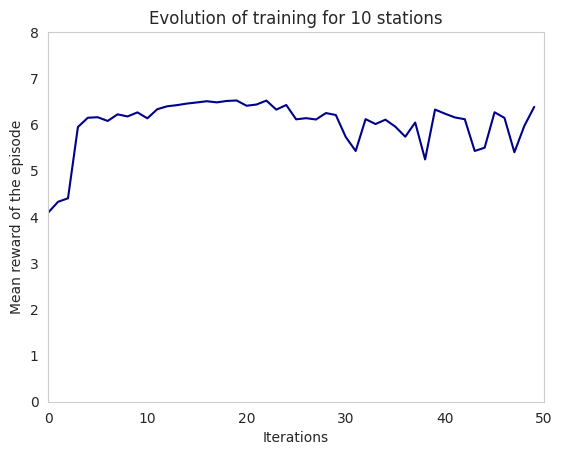

In [106]:
plt.plot(result_unified_10, color='darkblue')
plt.title("Evolution of training for 10 stations")
plt.xlabel("Iterations")
plt.ylabel("Mean reward of the episode")
plt.ylim(0, 8)
plt.xlim(0, 50)
plt.grid(False)

In [87]:
test_architecture = AcesStepArchitectureEnv(10)
latency_round_robin = []
latency_best_device = []
latency_algorithm = []
free_spaces = []
rewards = []

In [88]:
for i in range(100):
    obs = test_architecture.reset()
    test_architecture.architecture.round_robin()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_round_robin.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_server()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_best_device.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_algorithm()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    # print(test_architecture.architecture.compute_total_latency())
    iteration = {}
    allocation = []
    types = []
    reward = 0

    for i in range(20):
        action = algorithm_unified_10.compute_single_action(obs)
        output = test_architecture.step(action)
        obs = output[0]
        # print(obs['free_space'])
        reward += output[1]
        type = output[3]['type']
        iteration[i] = output[1]
        if type==0:
            for j in range(3):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(0)
        elif type==1:
            for j in range(6):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(1)
        elif type==2:
            for j in range(6):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(2)
        else:
            for j in range(5):
                for k in range(2):
                    if output[1] != -1:
                        allocation.append(action[k])
                        types.append(3)
                    else:
                        allocation.append(random.randint(0,1))
                        types.append(3)
        if output[2]:
            break

    test_architecture.architecture.false_data_allocation = allocation
    test_architecture.architecture.false_data_types = types
    test_architecture.architecture.false_construct_dictionaries()
    # print(iteration)
    latency_algorithm.append(test_architecture.architecture.false_compute_total_latency())
    free_spaces.append(test_architecture.architecture.false_free_space())
    rewards.append(reward)

(0.0, 99.0)

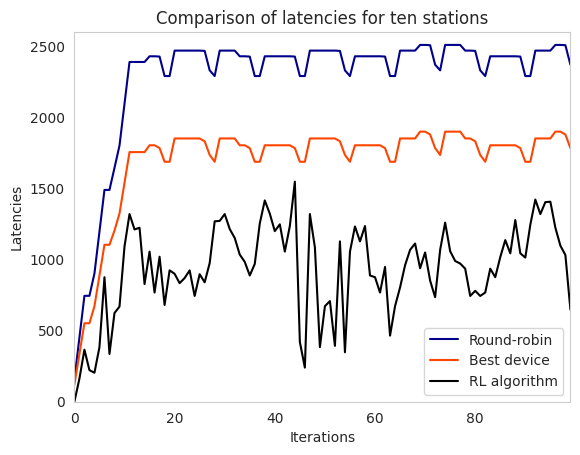

In [100]:
plt.plot(latency_round_robin, color='darkblue', label = "Round-robin")
plt.plot(latency_best_device, color='orangered', label = "Best device")
plt.plot(latency_algorithm, color='black', label = "RL algorithm")
plt.title("Comparison of latencies for ten stations")
plt.xlabel("Iterations")
plt.ylabel("Latencies")
plt.legend()
plt.grid(False)
plt.ylim(0, 2600)
plt.xlim(0, 99)

In [92]:
free_space_check = []

for fs_ind in range(len(free_spaces)):
    a=0
    for key in free_spaces[fs_ind].keys():
        if free_spaces[fs_ind][key] <= 0.2:
            a=rewards[fs_ind]
    free_space_check.append(a)

(0.0, 99.0)

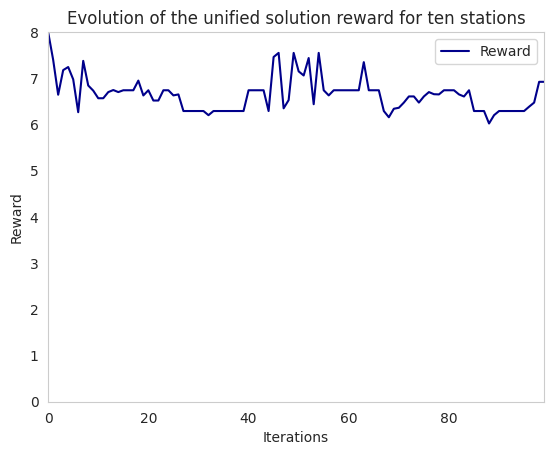

In [105]:
line=plt.plot(rewards, color='darkblue', label = "Reward")
# line=plt.plot(norm_rewards, color='orangered', label = "Normalized reward")
plt.title("Evolution of the unified solution reward for ten stations")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend()
plt.grid(False)
plt.ylim(0.0, 8)
plt.xlim(0, 99)

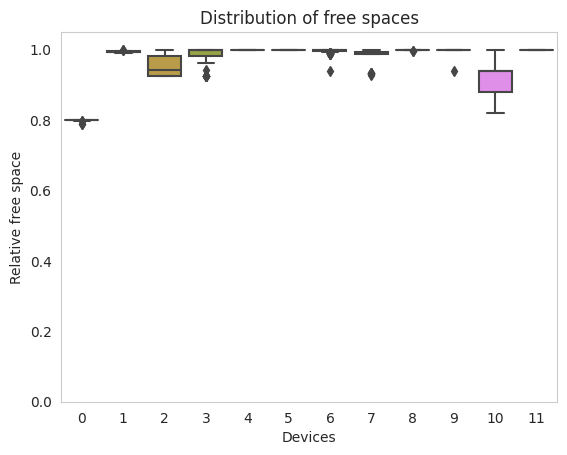

In [103]:
pre_dataframe = {}
for i in range(12):
    pre_dataframe[i] = []
for fs in free_spaces:
    for key in fs.keys():
        pre_dataframe[key].append(fs[key])
df = pd.DataFrame.from_dict(pre_dataframe)

ax = sns.boxplot(data=df).set(
    title="Distribution of free spaces",
    xlabel="Devices",
    ylabel="Relative free space",
    ylim=(0,1.05),
)
plt.grid(False)